# My <font color='brown'>MNIST</font> Adventure

本模組使用 [MNIST](http://yann.lecun.com/exdb/mnist/) 手寫數字資料庫，學習 sklearn 套件庫分類演算法的使用法以及鍛鍊各種 Python 技巧。


- [The Story of MNIST database (YouTube Video)](https://www.youtube.com/watch?v=oKzNUGz21JM)


接下來我們**要做這些事**：

Part 1

- 從 Yann LeCun 網站下載原始資料
- 解壓縮 gzip
- 解碼 idx 格式檔案 （MNIST only）
- 將 python 資料寫入 pickle
- 顯示單一字元 （用 matplotlib）
- 顯示 16 進位內容

-------
Part2

- 用 mnist 資料做 binary classification
	- Perceptron
- 多元分類
	- Logistic Regression
    - yellowbrick/mlxtend 套件介紹
	- Multiple Layer Perceptron
	- SVM


# ★ Importing libraries

In [2]:
!pip3 install --upgrade yellowbrick mlxtend

In [1]:
try:
    from google.colab import drive, files
    in_colab = True
except ModuleNotFoundError:
    in_colab = False

if in_colab:
    home_dir = ''
    drive.mount('/content/drive')
    groot_dir = '/content/drive/My Drive/adventures/'
else:
    from pathlib import Path
    home_dir = str(Path.home())
    groot_dir = home_dir + '\\Google Drive\\adventures\\'

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('font', size=14)

from datetime import datetime
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
import sklearn
assert sklearn.__version__ >= "0.20"
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import sys
# import gdown
import requests
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from pandas.plotting import register_matplotlib_converters

figure_dir = groot_dir + 'figure\\'
dataroot_dir = groot_dir
mnist_dir = groot_dir + 'mnist\\'

if not os.path.exists(mnist_dir):
    os.mkdir(mnist_dir)

covid_fig = 'covid\\'
mnist_fig = 'mnist\\'

gfigure = lambda name: figure_dir + name + '.png'
output_fig = lambda name: plt.savefig( gfigure(name), dpi = 300)

local_time = lambda x, offset: x + relativedelta(hours= offset)
def local_now(hours = 8):
    return datetime.now() + relativedelta(hours = hours if in_colab else 0)

def print_now():
    return print('Local Time:', local_now())

def print_local_now():
    return print('Local Time:', local_now())

def fetch_gdrive_file(fid, local_save):
    remote_url = 'https://drive.google.com/uc?id=' + fid
    gdown.download(remote_url, local_save, quiet = False)

def fetch_file_via_requests(url, save_in_dir):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    output_fpath = save_in_dir + local_filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_fpath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()
    return output_fpath
        
def acct_string(num):
    s0 = str(num)
    if len(s0) <=3:
        return s0  
    num_section = int(len(s0)/3)
    remaining_start = len(s0) % 3
    s = s0[:remaining_start]
    for i in range(num_section):
        s += ',%s' % s0[remaining_start + i*3 :remaining_start + (i+1)*3]   
    return s

TAIWAN_CSV = '1I5yqulrZSHPSQkxT3oqt_3uVAhPolOEP'
RED_WINE = '1ZDg4EfKkkjsWXfs4L3DkZhnAIfnq98Vk'
TITANIC_TRAIN = '1PrxmUKRQWSlYgtMU13l1E0ob4hVJI20O'
JHU_CSSE = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'
MNIST_TRAIN = '1E-uJ0zqqAfpsVjoOSzqF5TXhDfPNlkQ5'
MNIST_TRAIN_LABEL = '13clNJ2cd2I90W3DEkDBKjZSDNNEqqx3B'
MNIST_TEST = '1zVpVHJl5YABa3qExt1K-O3WaEHXTJekg'
MNIST_TEST_LABEL = '1qci_-dqubnRN-cdrCsbYaUAxyO7_jH9z'

print('\nThis module is amied to explore MNIST dataset...')

print('\nRunning on %s' % sys.platform)
print('Python Version', sys.version)
print('Data storage root points to ==>', groot_dir)
print('MNIST data will be stored at ==>', mnist_dir)
print('\nLibraries and dependenciess imported')
print_local_now()


This module is amied to explore MNIST dataset...

Running on win32
Python Version 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Data storage root points to ==> C:\Users\TyKA\Google Drive\adventures\
MNIST data will be stored at ==> C:\Users\TyKA\Google Drive\adventures\mnist\

Libraries and dependenciess imported
Local Time: 2021-03-07 14:53:26.571148


## ✔ Show MNIST digit helper 

### Confusion Matrix and ROC Plotter

In [2]:
from sklearn.metrics import r2_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib as mpl
import math
import itertools
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

def tf_diag(a):
    b = np.array(a).copy()
    rev_diag = np.diag(np.array(a))[::-1]
    for i, x  in enumerate(rev_diag):
        b[i][i] = x
    return b

def cm_transform(cm):
    newcm = np.zeros(cm.shape)
    for i in range(cm.shape[0]):
        newcm[i] = cm[:,i]
    return newcm.astype(np.int)

def my_plot_confusion_matrix(y_val, y_hat, target_names,
        title='CSP Confusion Matrix',
        figsize = (8, 6),
        cmap=None,
        normalize=True,
        ax = None):
    """
    given the observed and predicted values delivered by a classifier, make 
    a nice plot of the confusion matrix

    Arguments
    ---------
    y_val       : the observed values
    y_hat       : the predictced values
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                see http://matplotlib.org/examples/color/colormaps_reference.html
                plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                If True, plot the proportions
    """

    cm = confusion_matrix(y_val, y_hat)
    cm = tf_diag(cm) if cm.shape[0] == 2 else cm_transform(cm)

    n_classes = cm.shape[0]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    accuracy = accuracy_score(y_val, y_hat)

    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    else:
        fig = ax.figure

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.rcParams['xtick.labelsize']= 14
    plt.rcParams['ytick.labelsize']= 14
    plt.rcParams['axes.titlesize']= 14

    ax.set_title(title, fontsize = 14)
    fig.colorbar(ScalarMappable(norm=None, cmap=cmap), ax=ax)

    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    ax.set(xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=target_names,
        yticklabels=target_names,
        ylabel="Predicted label",
        xlabel="True label")
    
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            ax.text(j, i, "{:0.3f}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize = 18)
        else:
            ax.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize = 18)

    return ax

print('Loading my confusion matrix plotter ...')
print_local_now()

Loading my confusion matrix plotter ...
Local Time: 2021-03-07 14:53:26.690219


### How to display MNIST digits

- show_mnist_digit(): display bitmapped mnist digit
- show_digit_hex(): show hex value of mnist digit
- numpy.random.[randint](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html)

In [3]:
def show_mnist_digit(xdata, ydata, digit_index, add_noise = False, 
    title = None,
    outfile = ''):
    d = xdata[digit_index]
    d = np.reshape(d, (28, 28))
    if add_noise:
        anoise = np.random.randint(0, 100, (28, 28))
        d = d + anoise
    plt.imshow(d, cmap=plt.get_cmap('gray_r'))
    
    plt.title( ('mnist index ' if title is None else title) + f'{digit_index:d} = {ydata[digit_index]:d}' , 
        fontsize = 14)
    if (outfile):
        plt.savefig(gfigure(outfile), dpi = 300)
#     plt.show()
    
def show_digit_hex(data, digit_index):
    # if digit_index >= 10000: return
    d = data[digit_index]
    d = np.reshape(d, (28, 28)).astype(np.int)
    # print('begin show digits\n')
    for row in range(0, 28):
        for col in range(0, 28):
            print("%02X " % d[row][col], end="")
        print("") 

def predict_digit_viask(model, images, labels, to_be_checked = None):
        
    if to_be_checked is None:
        to_be_checked = np.random.randint(1, 10000, 1)
        
    d = images[to_be_checked].reshape(1, 28*28)
    y_guess = model.predict(d)

    # print('classifier %s prediction' % model_name)
    print('test set digit index [%d]' % to_be_checked)
    print('answer = %d , predicted = %d\n' % 
        (labels[to_be_checked], y_guess[0]) )
    
    prob_list = model.predict_proba(d)

    fig, ax = plt.subplots(1, 2, figsize=(10,5))

    ax[0].imshow(images[to_be_checked].reshape(28, 28), 
        cmap=plt.get_cmap('gray_r') )
    
    ax[0].set_title('MNIST Test Set: [%d] = %d' \
        % (to_be_checked, labels[to_be_checked]))
    ax[0].grid(b = 'on', alpha = 0.5, ls = '--')
    ax[1].bar(np.arange(10), prob_list[0])
#     ax[1].set_aspect(0.1)
    ax[1].set_xticks(np.arange(10))
    ax[1].set_yticks(np.arange(0,1.1,0.1))

    ax[1].grid('on', color = '#eeeeee', ls = '--')
    ax[1].set_title('Class %d Probability %0.3f' % (np.argmax(prob_list[0]), max(prob_list[0])))
    plt.tight_layout()
    # output_fig(mnist_fig + 'prediction %d' % to_be_checked)

print('Loading mnist digits plotting helpers')
print_now()

Loading mnist digits plotting helpers
Local Time: 2021-03-07 14:53:26.702907


# ① 下載原始檔 (download idx-coded mnist dataset)




檔案格式說明，參考下列連結：

- Yann LeCunn 網站提供 [idx](http://yann.lecun.com/exdb/mnist/) 格式[說明](http://www.fon.hum.uva.nl/praat/manual/IDX_file_format.html)，mlxtend 也提供以 Python 如以 mlxtend 套件[載入資料庫](http://rasbt.github.io/mlxtend/user_guide/data/loadlocal_mnist/)的說明。

- [Kaggle](https://www.kaggle.com/ngbolin/mnist-dataset-digit-recognizer) 上有 csv 格式的說明

- [MNIST Dataset Python Example Using CNN](https://towardsdatascience.com/mnist-cnn-python-c61a5bce7a19)

- [Using MNIST](https://www.python-course.eu/neural_network_mnist.php)

- [np.fromfile](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fromfile.html) API 說明

### MNIST website URL

In [4]:
train_data_file =   'train-images-idx3-ubyte'
train_label_file =  'train-labels-idx1-ubyte'
test_data_file =  't10k-images-idx3-ubyte'
test_label_file =  't10k-labels-idx1-ubyte'

mnist_host = 'http://yann.lecun.com/exdb/mnist/'

mnist_files = [train_data_file, train_label_file, 
    test_data_file, test_label_file]

### 直接從 Yann Lecun 維護的網站下載資料

- [Python GZip](https://docs.python.org/3/library/gzip.html)
- [How to unzip gz file using Python](https://stackoverflow.com/questions/31028815/how-to-unzip-gz-file-using-python)

- [MNIST dataset provided by Yann Lecun](http://yann.lecun.com/exdb/mnist/)

In [8]:
%%time

import gzip
import shutil

def un_gzip(original, uncompressed):
    with gzip.open(original, 'rb') as f_in:
        with open(uncompressed, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
            print('%s uncompressed to %s'%(original, uncompressed))

for dfile in mnist_files:
    remote_file = mnist_host + dfile + ".gz"
    local_file = mnist_dir + dfile + ".gz"
    result = mnist_dir + dfile
    
    fetch_file_via_requests(remote_file, mnist_dir)
    un_gzip(local_file, result)
    
print("mnist database fetched")

C:\Users\TyKA\Google Drive\adventures\mnist\train-images-idx3-ubyte.gz uncompressed to C:\Users\TyKA\Google Drive\adventures\mnist\train-images-idx3-ubyte
C:\Users\TyKA\Google Drive\adventures\mnist\train-labels-idx1-ubyte.gz uncompressed to C:\Users\TyKA\Google Drive\adventures\mnist\train-labels-idx1-ubyte
C:\Users\TyKA\Google Drive\adventures\mnist\t10k-images-idx3-ubyte.gz uncompressed to C:\Users\TyKA\Google Drive\adventures\mnist\t10k-images-idx3-ubyte
C:\Users\TyKA\Google Drive\adventures\mnist\t10k-labels-idx1-ubyte.gz uncompressed to C:\Users\TyKA\Google Drive\adventures\mnist\t10k-labels-idx1-ubyte
mnist database fetched
Wall time: 6.51 s


### 從遠端 Goggle Drive 下載 ( Fetching shared resources)

In [ ]:
fetch_gdrive_file(MNIST_TRAIN, 
    os.path.join(mnist_dir, train_data_file ))
fetch_gdrive_file(MNIST_TRAIN_LABEL, 
    os.path.join(mnist_dir, train_label_file ))
fetch_gdrive_file(MNIST_TEST, 
    os.path.join(mnist_dir, test_data_file ))
fetch_gdrive_file(MNIST_TEST_LABEL, 
    os.path.join(mnist_dir, test_label_file))

## Read dataset and dump pickle  ✔

Yann LeCunn 維護的 MNIST 資料已經下載回來，放在 ～/Google Drive/adventures/mnist/。以下程式將 idx 格式的檔案載入記憶體，以 Pandas DataFrame 格式封裝起來。為了日後使用方便，並將 DataFrame 內容以 Python 內建的 `Pickle` 格式存入本地硬碟。


讀入資料後，分成兩個資料集 `train` & `test`，兩個資料集的 shape 以及資料筆數如下述：

- shape of train_x (60000, 784)
- shape of train_y (60000,)
- shape of test_x (10000, 784)
- shape of test_x (10000,)

dump datafram to pickle 時，應該儲存**沒有處理**過（label smoothing, nomalization）的資料。下次取出來使用的時候，依照當時需求，實驗目的，再做必要的 preprocessing or feature engingeering 即可

### read_idx (要預先載入)

In [5]:
import struct, pickle
from scipy.ndimage.interpolation import shift

def read_idx(filename):
    with open(filename,'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        if (dims == 3):
            n = struct.unpack('>I', f.read(4))[0]
            r = struct.unpack('>I', f.read(4))[0]
            c = struct.unpack('>I', f.read(4))[0]
            shape = (n, r, c)
        else:
            n = struct.unpack('>I', f.read(4))[0]
            shape = (n)
#         print('idx shape =', shape)
        return np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))


### 讀入 idx file，然後寫入 pickle

In [6]:
# read origin data

raw_train = read_idx(mnist_dir + train_data_file)
train_data = np.reshape(raw_train, (60000, 28*28))
train_y = read_idx(mnist_dir + train_label_file)

raw_test = read_idx(mnist_dir + test_data_file)
test_data = np.reshape(raw_test, (10000, 28*28))
test_y = read_idx(mnist_dir + test_label_file)

In [7]:
import pickle

with open(mnist_dir + "clean_mnist.pkl", "bw") as fh:
    data = (train_data, train_y, test_data, test_y)
    pickle.dump(data, fh)

## 也可以使用 fetch_openml 

-  [fetch_openml](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html?highlight=fetch_openml#sklearn.datasets.fetch_openml) API

In [11]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
# mnist.keys()

X, y = mnist["data"], mnist["target"]

Train_X, Train_y= X[:60000], y[:60000]
test_X, test_y = X[10000:], y[10000:]

## Load previously stored pickle for demo purpose

Load the pickled mnist digits into data frames **train_data**, **y_train**, test_data and y_test

In [12]:
import pickle

pkl_path = os.path.join(mnist_dir + "clean_mnist.pkl")

with open(pkl_path, "br") as fh:
    (train_data, y_train, test_data, y_test) = pickle.load(fh)

print(train_data.shape, y_train.shape)
print(test_data.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


## How to display hand-written digits ✌

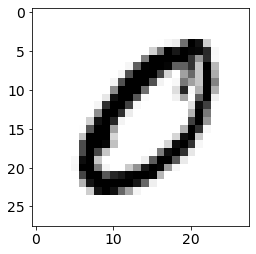

In [13]:
dindex = 1107
d = train_data[dindex]
d = d.reshape(28, 28)
plt.imshow(d, cmap = "gray_r")

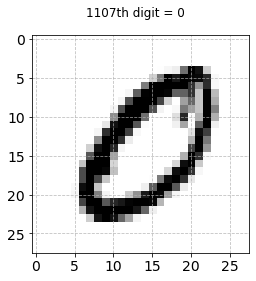

In [14]:
def show_mnist_digit2(xdata, ydata, idx):
    d = xdata[idx]
    d = d.reshape(28, 28)
    plt.imshow(d, cmap = "gray_r")
    plt.grid(b = "on", which="major", ls = "--", alpha = 0.8)
    plt.xticks(range(0, 28, 5), ["%d" % x for x in range(0, 28, 5)])
    plt.suptitle(f"{idx}th digit = {ydata[idx]:d}")

show_mnist_digit2(train_data, y_train, 1107)

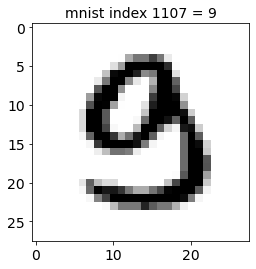

In [15]:
show_mnist_digit(test_data, y_test, 1107)

In [16]:
def show_mnist_hex(x_data, y_data, idx):
    d = x_data[idx]
    d = d.reshape(28, 28)
    for row in range(0, 28):
        for col in range(0, 28):
            print("%02X " %d[row][col], end = "")
        print("")

show_mnist_hex(train_data, y_train, 107)

00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 4F BF FF FD FD FD 3F 00 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 2A 49 73 F2 FC FD FC FC FC EE 9A 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 1B DD FD FC FC FC FD FC FC FC FD BE 0B 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 25 FC FD D2 6C 6C 6C 6C 80 FC FD FC 47 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 53 53 00 00 00 00 00 25 FC FD FC 47 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 15 B5 FC FD BD 0A 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 B0 FC FC ED 47 00 00 00 00 00 00 00 
00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 91 ED FC FC 90 00 00

# ② scikit-learn and MNIST

## ★ Load Pickled MNIST Data

In [17]:
pkl_path = os.path.join(mnist_dir, "clean_mnist.pkl")

with open(pkl_path, "br") as fh:
    (train_data, y_train, test_data, y_test) = pickle.load(fh)

print("pickled data loaded into memory")

pickled data loaded into memory


In [18]:
train_data[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

In [19]:
# label smoothing

fac = 0.99 / 255
x_train = train_data * fac + 0.01
x_test = test_data * fac + 0.01 

In [20]:
x_train[0]

array([0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01   

In [21]:
# 重新確認結構是一樣的
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

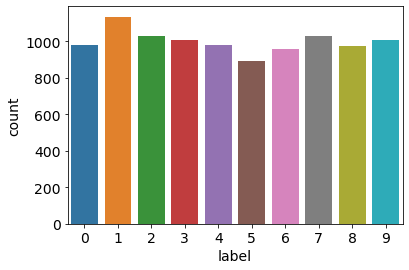

In [22]:
cnt = pd.DataFrame()
cnt["label"] = y_test
ax = sns.countplot(x = "label", data=cnt)

In [23]:
cnt.label.value_counts().sort_index()

0     980
1    1135
2    1032
3    1010
4     982
5     892
6     958
7    1028
8     974
9    1009
Name: label, dtype: int64

## Binary Classification
- [SGDClassfier: regularized linear models with stochastic gradient descent (SGD) learning](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [Cross Validation Score (cross_val_score)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html?highlight=cross_val_score#sklearn.model_selection.cross_val_score)
- [sklearn.metrics.plot_confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html?highlight=plot_confusion_matrix#sklearn.metrics.plot_confusion_matrix)

In [24]:
y_train_9 = (y_train == 9)
type(y_train_9)

numpy.ndarray

In [25]:
y_train_9

array([False, False, False, ..., False, False, False])

In [26]:
y_test_9 = (y_test == 9)
y_test_9

array([False, False, False, ..., False, False, False])

### 向感知器致敬

In [27]:
%%time
from sklearn.linear_model import SGDClassifier, Perceptron

pen = Perceptron()
pen.fit(x_train, y_train_9)

Wall time: 1.21 s


Perceptron()

In [28]:
our_prediction = pen.predict([x_train[0]])
our_prediction, y_test[0]

(array([False]), 7)

In [29]:
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix

y_hat = pen.predict(x_test)
rep = classification_report(y_test_9, y_hat)
print(rep)

              precision    recall  f1-score   support

       False       0.98      0.96      0.97      8991
        True       0.71      0.85      0.77      1009

    accuracy                           0.95     10000
   macro avg       0.85      0.90      0.87     10000
weighted avg       0.96      0.95      0.95     10000



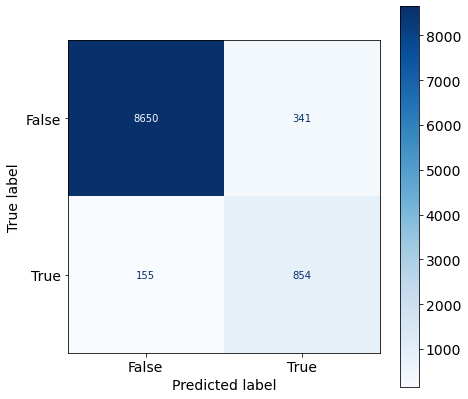

In [30]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(pen, x_test, y_test_9, ax = ax, cmap = "Blues", 
                     values_format="d")

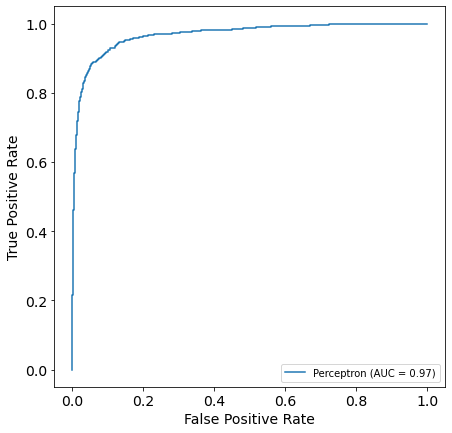

In [31]:
fig, ax = plt.subplots(figsize = (7, 7))
plot_roc_curve(pen, x_test, y_test_9, ax = ax)

In [32]:
%%time
from sklearn.model_selection import cross_val_score

pen2 = Perceptron()
scores = cross_val_score(pen, x_train, y_train_9, cv = 5)
print(scores)

[0.95566667 0.93791667 0.95466667 0.95041667 0.93383333]
Wall time: 4.4 s


### SGD Classifier

In [33]:
clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
clf.fit(x_train, y_train_9)

y_hat_sgd = clf.predict(x_test)

In [34]:
rep = classification_report(y_test_9, y_hat_sgd)
print(rep)

              precision    recall  f1-score   support

       False       0.97      0.99      0.98      8991
        True       0.92      0.72      0.81      1009

    accuracy                           0.97     10000
   macro avg       0.95      0.86      0.90     10000
weighted avg       0.96      0.97      0.96     10000



<AxesSubplot:title={'center':'CSP Confusion Matrix'}, xlabel='True label', ylabel='Predicted label'>

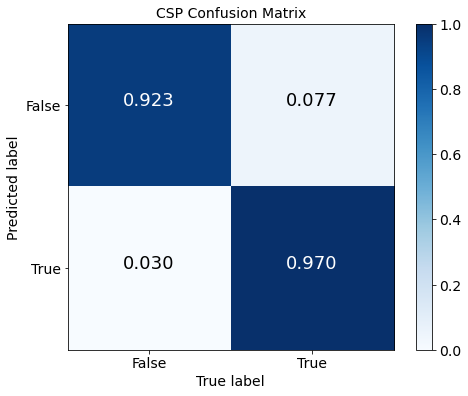

In [35]:
my_plot_confusion_matrix(y_test_9, y_hat_sgd, ["False", "True"])

## Multi-class Classification

### Logistic Regression

- [sklearn: Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Linear Model](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix

lr = LogisticRegression(max_iter=500)
lr.fit(x_train, y_train)
y_hat_lr = lr.predict(x_test)

print("-"*20)
print("Train score: %.4f" %lr.score(x_train, y_train))
print("Test score: %.4f" %lr.score(x_test, y_test))
print("-"*20)

rep = classification_report(y_test, y_hat_lr)
print(rep)


C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------
Train score: 0.9392
Test score: 0.9257
--------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.92      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.94      0.94       982
           5       0.90      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



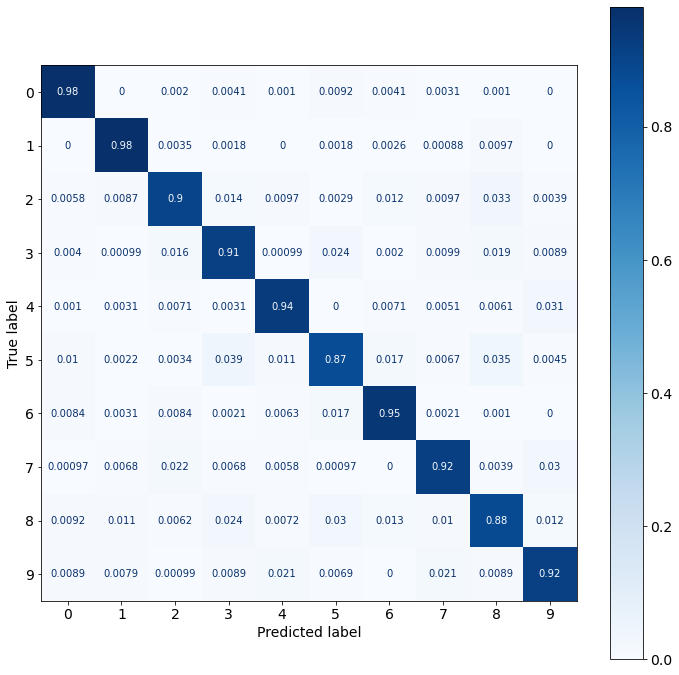

In [42]:
fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(lr, x_test, y_test, ax = ax, cmap = "Blues", normalize="true")

In [44]:
probs = lr.predict_proba([x_test[0]])
probs

array([[4.64248756e-07, 1.27348853e-13, 1.22787622e-06, 2.58352021e-03,
        6.22745770e-08, 1.16505374e-05, 6.05582013e-12, 9.97199494e-01,
        6.53627371e-06, 1.97044528e-04]])

In [45]:
y_test[0]

7

[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5'),
 Text(6, 0, '6'),
 Text(7, 0, '7'),
 Text(8, 0, '8'),
 Text(9, 0, '9')]

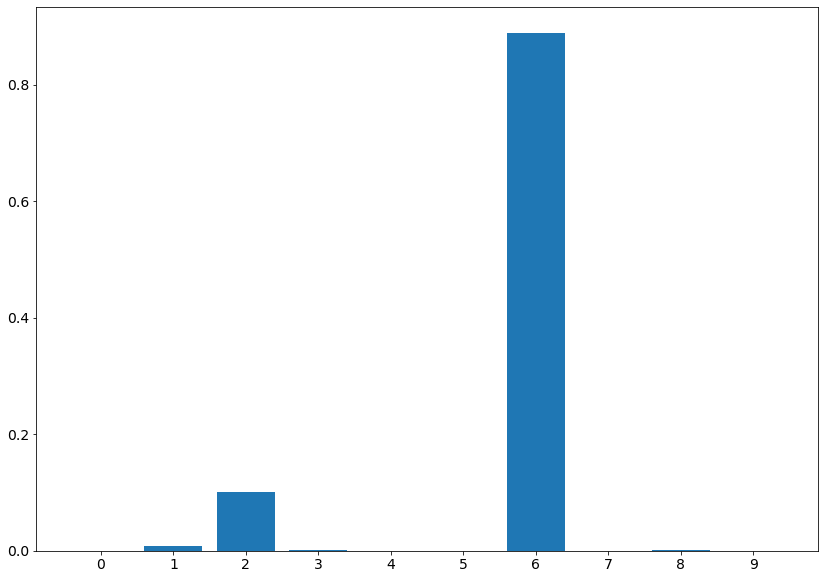

In [48]:
probs = lr.predict_proba([x_test[100]])

fig, ax = plt.subplots(figsize = (14, 10))
ax.bar(range(10), probs[0])
ax.set_xticks(range(10))
ax.set_xticklabels(["%d" %x for x in range(10)])

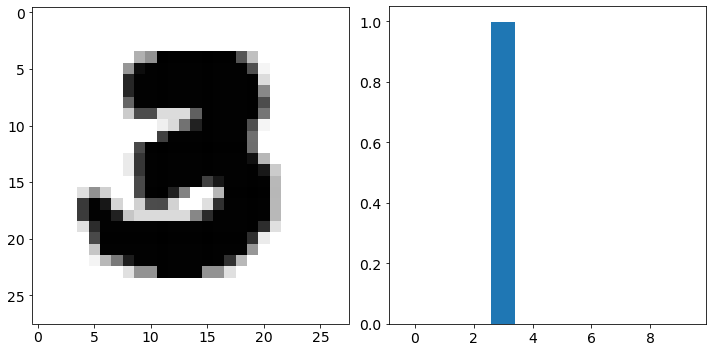

In [50]:
idx = 200

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
d = x_test[idx].reshape(28, 28)
ax[0].imshow(d, cmap = "gray_r")

probs = lr.predict_proba([x_test[idx]])[0]
ax[1].bar(range(10), probs)
plt.tight_layout()

test set digit index [200]
answer = 3 , predicted = 3



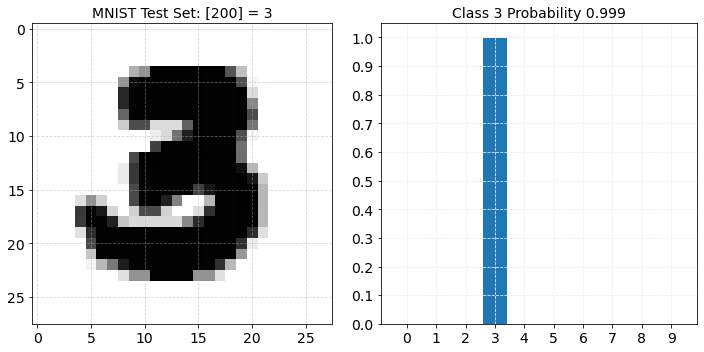

In [51]:
predict_digit_viask(lr, x_test, y_test, 200)

In [56]:
lr_errs = []

for i in range(len(y_test)):
    if y_hat_lr[i] != y_test[i]:
        lr_errs.append(i)

print(lr_errs)

[8, 33, 63, 66, 124, 149, 193, 195, 211, 217, 233, 241, 245, 247, 259, 307, 313, 320, 321, 340, 344, 352, 362, 381, 403, 406, 412, 425, 435, 444, 445, 448, 469, 478, 479, 502, 507, 528, 531, 536, 542, 543, 551, 565, 569, 578, 582, 583, 591, 613, 619, 629, 659, 684, 691, 692, 707, 717, 720, 728, 740, 741, 760, 781, 791, 829, 839, 844, 857, 877, 881, 882, 890, 898, 924, 938, 939, 947, 950, 951, 956, 959, 965, 975, 999, 1003, 1012, 1014, 1017, 1028, 1032, 1039, 1044, 1062, 1068, 1082, 1101, 1107, 1112, 1114, 1128, 1157, 1178, 1181, 1182, 1191, 1192, 1194, 1198, 1202, 1204, 1206, 1226, 1232, 1233, 1234, 1242, 1247, 1256, 1260, 1283, 1299, 1310, 1319, 1320, 1325, 1326, 1337, 1364, 1378, 1393, 1410, 1413, 1433, 1440, 1444, 1466, 1494, 1500, 1522, 1525, 1527, 1530, 1549, 1553, 1559, 1569, 1581, 1587, 1609, 1634, 1640, 1681, 1686, 1696, 1709, 1717, 1718, 1722, 1751, 1754, 1765, 1772, 1773, 1774, 1790, 1800, 1813, 1828, 1850, 1855, 1878, 1883, 1899, 1901, 1917, 1926, 1938, 1940, 1941, 1942, 195

In [57]:
len(lr_errs)

743

test set digit index [8]
answer = 5 , predicted = 6

test set digit index [33]
answer = 4 , predicted = 6

test set digit index [63]
answer = 3 , predicted = 2

test set digit index [66]
answer = 6 , predicted = 2

test set digit index [124]
answer = 7 , predicted = 4



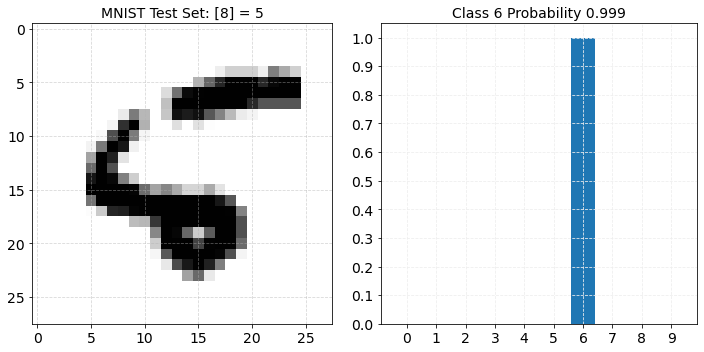

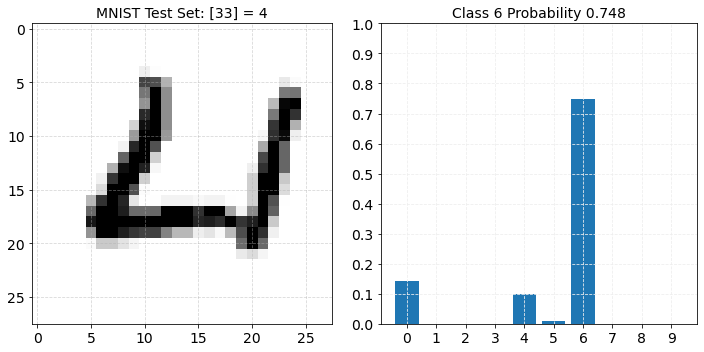

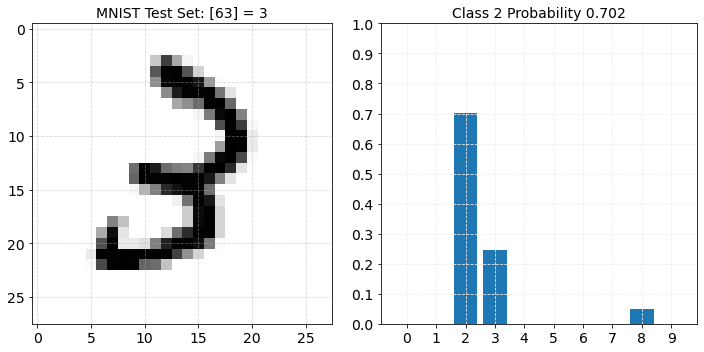

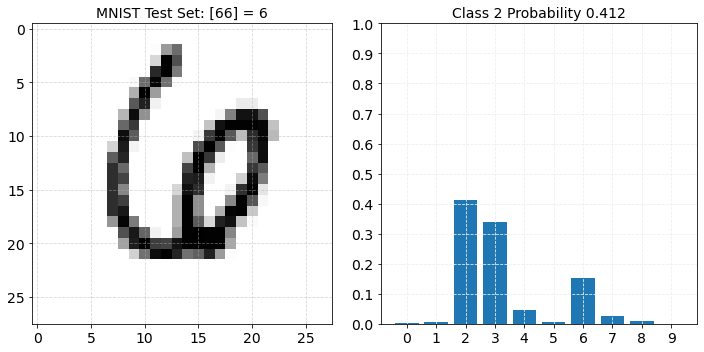

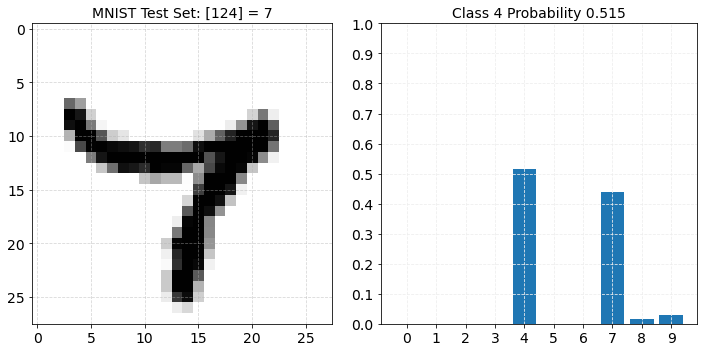

In [58]:
for i in lr_errs[:5]:
    predict_digit_viask(lr, x_test, y_test, to_be_checked=i)

### YellowBrick ClassificationReport

- [YellowBrick](https://www.scikit-yb.org/en/latest/quickstart.html) [ClassificationReport](https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html) API



C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


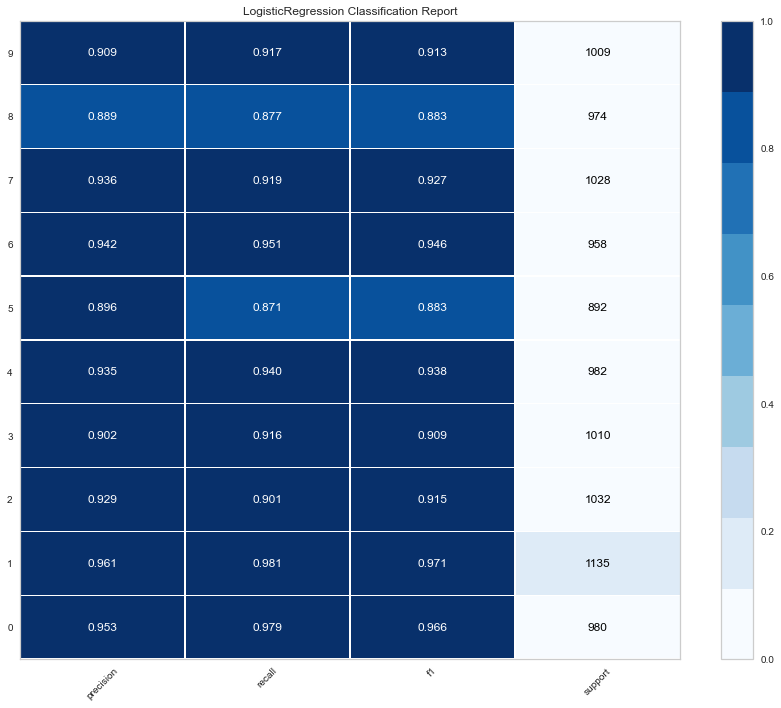

Wall time: 20.2 s


<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [59]:
%%time

from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=200)

digits = ["%d" %i for i in range(10)]

plt.figure(figsize = (12, 10))
visualizer = ClassificationReport(model, classes = digits,
                                 support=True, cmap = "Blues")
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show()

### mlxtend plot_confusion_matrix

- mlxtend [plot_confusion_matrix](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/) user guide

(Google Colab 提供的版本太舊，需要自行安裝最新版)

```
!pip3 install --upgrade mlxtend
```

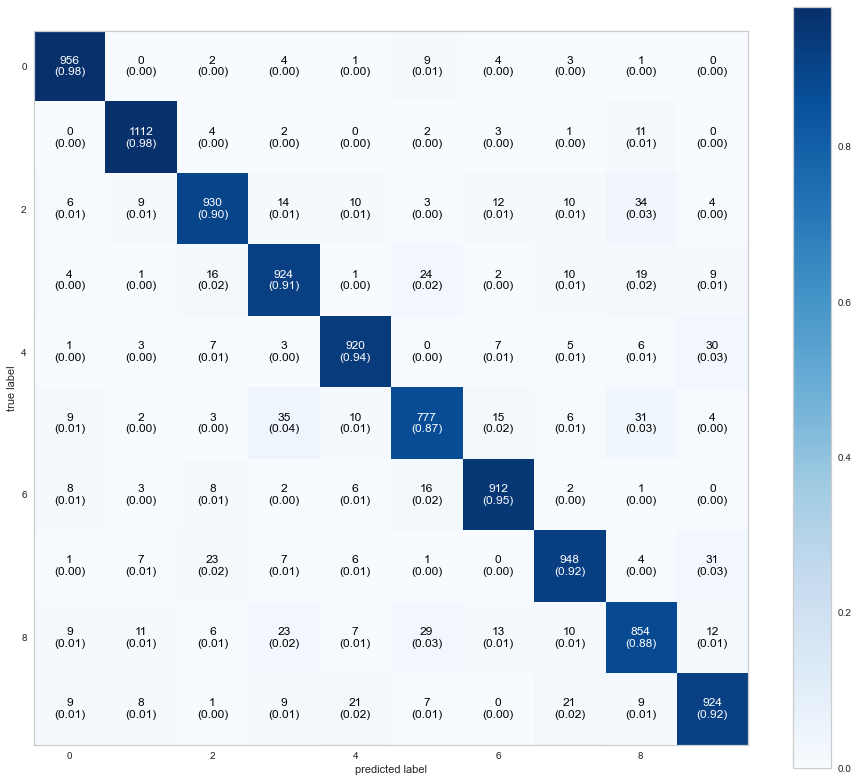

In [62]:
from mlxtend.plotting import plot_confusion_matrix as plot_cm3
from sklearn.metrics import confusion_matrix
mix_cm = confusion_matrix(y_test, y_hat_lr)

fig, ax = plot_cm3(conf_mat=mix_cm, show_normed=True, colorbar="True",
                   figsize = (16, 14))

#### same as sklearn, but more sphiscated

### k-Nearest Neighbor

In [66]:
%%time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn = KNeighborsClassifier(n_neighbors=3, algorithm="auto")
knn.fit(x_train, y_train)

y_hat_knn = knn.predict(x_test)
rep_knn = classification_report(y_test, y_hat_knn)
print(rep_knn)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.96      1.00      0.98      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Wall time: 12min 17s


### Multi Layer Perceptron

In [65]:
%%time

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

mlp = MLPClassifier(hidden_layer_sizes=(128, ), max_iter=100,
                    activation="tanh", tol=1e-4, random_state=0, 
                    learning_rate_init=0.005, shuffle= True,
                    verbose = False, learning_rate="adaptive")

mlp.fit(x_train, y_train)
y_hat_mlp = mlp.predict(x_test)

rep = classification_report(y_test, y_hat_mlp)
print(rep)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.97      0.96      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Wall time: 49 s


### SVM

- [sklearn Support Vector Machines](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)

In [67]:
from sklearn.svm import SVC, LinearSVC

sv = SVC(kernel="linear")

svl = LinearSVC()

sv.fit(x_train, y_train)
y_hat_sv = sv.predict(x_test)
rep_sv = classification_report(y_test, y_hat_sv)

svl.fit(x_train, y_train)
y_hat_svl = svl.predict(x_test)
rep_svl = classification_report(y_test, y_hat_svl)

print(rep_sv)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.97      0.99      0.98      1135
           2       0.93      0.94      0.93      1032
           3       0.91      0.94      0.92      1010
           4       0.93      0.96      0.95       982
           5       0.92      0.90      0.91       892
           6       0.96      0.95      0.95       958
           7       0.95      0.93      0.94      1028
           8       0.94      0.90      0.92       974
           9       0.95      0.91      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [68]:
print(rep_svl)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.89      0.91      1032
           3       0.90      0.91      0.90      1010
           4       0.92      0.93      0.92       982
           5       0.89      0.86      0.88       892
           6       0.94      0.95      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.88      0.87      0.87       974
           9       0.90      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



# 下一個單元

- https://reurl.cc/g7y7Ab